#**HW4 : Recurrent Neural Networks**
In this homework, we will explore how to develop a simple Recurrent Neural Network (RNN) for sentiment analysis. As a dataset, we will use the IMDB dataset. It contains the text of some reviews and the sentiment given by the authors of the reviews (positive review or negative review). The input to the RNN is the sequence of words that compose a review. The learning task consists in predicting the sentiment of the review.
In the first part, we will learn how to develop a simple RNN, then we will explore the differences in terms of computational load, number of parameters, and performances with respect to more advanced recurrent models, like LSTM and GRU. Subsequently, we experiment with the bi-directional model to unveil the strengths and the weaknesses of this technique. Finally, we will explore how to face overfitting by Dropout. 

##[TO COMPLETE] Exercise 4.1: Simple RNN

Let's start by importing Tensorflow, Keras and Numpy

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

np.random.seed(42)

###Load dataset:
In this HW, we use the same datset used in the HW2, the IMDB dataset. The dataset contains 50,000 movie reviews from IMDB, labeled by sentiment (positive/negative). Reviews have been preprocessed, and each review is encoded as a sequence of word indexes. For convenience, the words are indexed by the overall frequency in the dataset, so that for example the integer "3" encodes the 3rd most frequent word in the data. For testing purposes, we will only consider the first 10,000  most common words.
By default, the load_data method returns a breakdown of the dataset into training and test sets. Both these sets contain 25,000 samples. To also have a validation set, we split the test set in half.

In [ ]:

num_words = 10000
(X_train, y_train), (X_test, y_test) = keras.datasets.imdb.load_data(num_words=num_words)
(X_valid, X_test) = X_test[:12500], X_test[12500:]
(y_valid, y_test) = y_test[:12500], y_test[12500:]

17465344/17464789 [==============================] - 0s 0us/step


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

Let's also get the word indexs (word to word-id)

In [ ]:
word_index = keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


Now we create a reverse index (word-id to word) method. Moreover, we add three special word-ids to encode:
- the padding;
- the start of a sequence;
- a word that is not in the vocabulary of the first 10,000 most common words.

Moreover, we also add an "unknown" placeholder for all the other symbols (not words) that may occur.
*Please, notice that Keras does not use index 0, so we can shift the indices only by 3 positions.*

In [ ]:
reverse_index = {word_id + 3: word for word, word_id in word_index.items()}
reverse_index[0] = "<pad>" # padding
reverse_index[1] = "<sos>" # start of sequence
reverse_index[2] = "<oov>" # out-of-vocabulary
reverse_index[3] = "<unk>" # unknown

def decode_review(word_ids):
    return " ".join([reverse_index.get(word_id, "<err>") for word_id in word_ids])

Let's print a training sample and its target value

In [ ]:
decode_review(X_train[0])

"<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <oov> is an amazing actor and now the same being director <oov> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <oov> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <oov> to the two little boy's that played the <oov> of norman and paul they were just brilliant children are often left out of the <oov> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what

In [ ]:
y_train[0]

1

Because of a limit of Keras, to feed the input data into an RNN model we have to create sequences that have the same length. We use keras.preprocessing.sequence.pad_sequences() to preprocess X_train: this will create a 2D array of 25,000 rows (one per review) and maxlen=500 columns. Because of that, reviews longer than 500 words will be cut, while reviews shorter than 500 words will be padded with zeros.

In [ ]:
maxlen = 500
X_train_trim = keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen)
X_test_trim = keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen)
X_valid_trim = keras.preprocessing.sequence.pad_sequences(X_valid, maxlen=maxlen)

###[TO COMPLETE] Define the model:
Let's define the model: 
- The first layer is an Embedding layer, with input_dim=num_words and output_dim=10. The model will gradually learn to represent each of the 10,000 words as a 10-dimensional vector. So the next layer will receive 3D batches of shape (batch size, 500, 10)
- The second layer is the recurrent one. In particular, in this case, we use a [SimpleRNN](https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN) 
- The output layer is a Dense layer with a sigmoid activation function since this is a binary classification problem

[TO COMPLETE] In the following cell, we already inserted in the model the first Embedding layer. Add the recurrent layer (using 32 units), and the output layer. Select the right activation function for the output layer and motivate your choice. Finally, select the right loss function inserting the right value for the "loss" parameter in model.compile() and motivate your choice.
Please, insert your answers in a new text cell below this one, immediately before the code.

ANSWER : The output activation function that I chose is sigmoid because the task requires a binary classification then this function is between (0 to 1). Binary cross entropy is a loss function that is used in binary classification tasks and is the only compatible with sigmoid.

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.SimpleRNN(32))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

Let's print a summary of the model. Specifically, note the number of parameters of the RNN layer.

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          100000    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 32)                1376      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 101,409
Trainable params: 101,409
Non-trainable params: 0
_________________________________________________________________


###Train the model:
Now we have to train the model

In [ ]:
history = model.fit(X_train_trim, y_train,
                    epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

Epoch 1/10
196/196 [==============================] - 28s 135ms/step - loss: 0.6943 - accuracy: 0.5168 - val_loss: 0.6808 - val_accuracy: 0.5680
Epoch 2/10
196/196 [==============================] - 26s 132ms/step - loss: 0.6495 - accuracy: 0.6580 - val_loss: 0.6048 - val_accuracy: 0.6659
Epoch 3/10
196/196 [==============================] - 26s 132ms/step - loss: 0.4771 - accuracy: 0.7820 - val_loss: 0.4944 - val_accuracy: 0.7642
Epoch 4/10
196/196 [==============================] - 26s 131ms/step - loss: 0.2976 - accuracy: 0.8814 - val_loss: 0.4184 - val_accuracy: 0.8275
Epoch 5/10
196/196 [==============================] - 26s 131ms/step - loss: 0.1820 - accuracy: 0.9347 - val_loss: 0.4469 - val_accuracy: 0.8218
Epoch 6/10
196/196 [==============================] - 27s 137ms/step - loss: 0.1013 - accuracy: 0.9704 - val_loss: 0.4971 - val_accuracy: 0.8158
Epoch 7/10
196/196 [==============================] - 27s 139ms/step - loss: 0.0633 - accuracy: 0.9831 - val_loss: 0.5674 - val_ac

Print the values of accuracy and the loss , and evaluate the model on the test set

391/391 - 8s - loss: 0.7266 - accuracy: 0.7990
accuracy: 79.90%


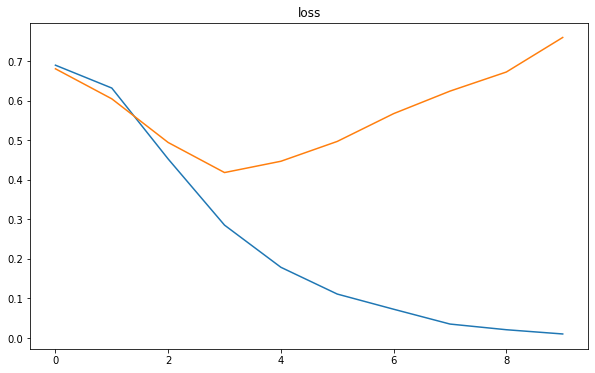

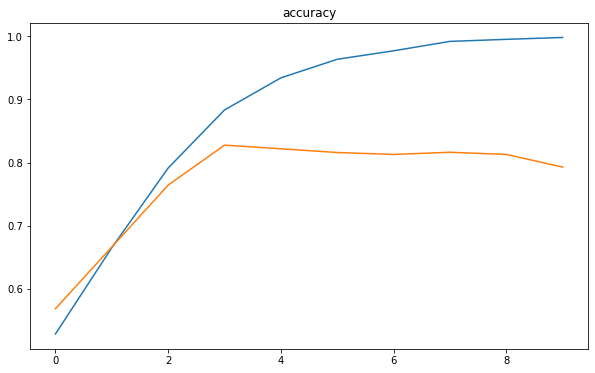

In [ ]:
def plot_loss(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['loss'])
  plt.plot(history.epoch,history.history['val_loss'])
  plt.title('loss')

def plot_accuracy(history):
  plt.figure(figsize=(10,6))
  plt.plot(history.epoch,history.history['accuracy'])
  plt.plot(history.epoch,history.history['val_accuracy'])
  plt.title('accuracy')

plot_loss(history)

plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.2: LSTM and GRU
**[TO COMPLETE]**: In this Exercise, you have to implement 2 models, similar to the previous one that, instead of exploiting the RNN layer, use an LSTM and a GRU Layer, respectively. For each model print the summary. Then, train it and plot the values of accuracy and loss. Finally, discuss the differences in terms of performance, the number of parameters, and training time. Note that you can use a different number of units than the one used in the RNN example.

**[TO COMPLETE]**: In order to perform a fair comparison (definition of fair: models have to use more or less the same number of parameters) between the given RNN model and the other 2 models (LSTM and GRU), how many units do they have to use, respectively?

*insert cells (code and text) with results and discussion immediately after this cell*

Units for GRU : 16, Units for LSTM : 13 and Units for Simple RNN : 32

Parameters for GRU = 101,361 , Parameters  for LSTM = 101,262 and Parameters for Simple RNN = 101,409

Score:

Simple RNN - loss: 0.7266 - accuracy: 0.7990

LSTM - loss: 0.4839 - accuracy: 0.8561

GRU - loss: 0.4565 - accuracy: 0.8547


Discussion:
- Performance - The LSTM method is performing better than GRU and Simple RNN but in all cases we are overfitting, it is important to notice that the result are close one to each other, and they are not a significant improvement between the two new method proposed.
- Parameters - I considered some units more for GRU method compared to LSTM in order to have more or less the same parameters for all the cases.
- Training Time (epochs=5, batch_size=128) - As I expected, Simple RNN is two times faster than GRU-LSTM. The last two mentioned  are very similar for the time comparison.

Epoch 1/10
196/196 [==============================] - 51s 251ms/step - loss: 0.6480 - accuracy: 0.6162 - val_loss: 0.4177 - val_accuracy: 0.8287
Epoch 2/10
196/196 [==============================] - 50s 253ms/step - loss: 0.3609 - accuracy: 0.8562 - val_loss: 0.3432 - val_accuracy: 0.8536
Epoch 3/10
196/196 [==============================] - 50s 253ms/step - loss: 0.2204 - accuracy: 0.9241 - val_loss: 0.3331 - val_accuracy: 0.8551
Epoch 4/10
196/196 [==============================] - 49s 252ms/step - loss: 0.1741 - accuracy: 0.9437 - val_loss: 0.3192 - val_accuracy: 0.8669
Epoch 5/10
196/196 [==============================] - 52s 265ms/step - loss: 0.1468 - accuracy: 0.9537 - val_loss: 0.3536 - val_accuracy: 0.8694
Epoch 6/10
196/196 [==============================] - 51s 262ms/step - loss: 0.1125 - accuracy: 0.9654 - val_loss: 0.3602 - val_accuracy: 0.8642
Epoch 7/10
196/196 [==============================] - 52s 263ms/step - loss: 0.0998 - accuracy: 0.9707 - val_loss: 0.3985 - val_ac

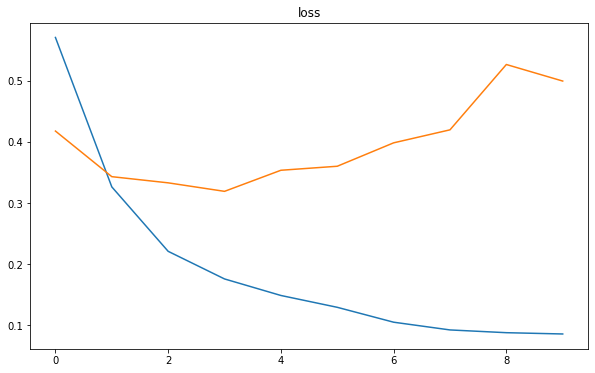

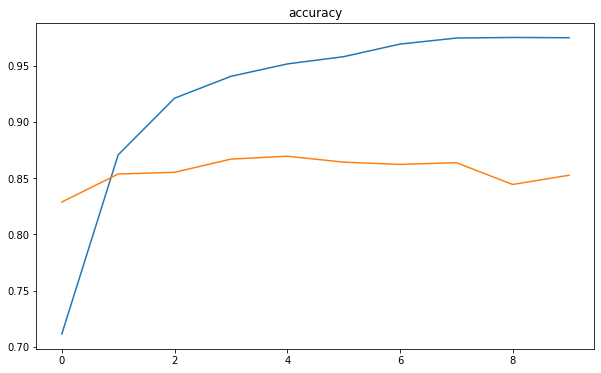

In [ ]:
#LSTM
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.LSTM(13))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train_trim, y_train,epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

model.summary()

plot_loss(history)
plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/10
196/196 [==============================] - 49s 241ms/step - loss: 0.6578 - accuracy: 0.5822 - val_loss: 0.3821 - val_accuracy: 0.8358
Epoch 2/10
196/196 [==============================] - 50s 257ms/step - loss: 0.2997 - accuracy: 0.8792 - val_loss: 0.3459 - val_accuracy: 0.8573
Epoch 3/10
196/196 [==============================] - 50s 257ms/step - loss: 0.2156 - accuracy: 0.9204 - val_loss: 0.3175 - val_accuracy: 0.8708
Epoch 4/10
196/196 [==============================] - 50s 254ms/step - loss: 0.1678 - accuracy: 0.9422 - val_loss: 0.3454 - val_accuracy: 0.8688
Epoch 5/10
196/196 [==============================] - 50s 256ms/step - loss: 0.1465 - accuracy: 0.9503 - val_loss: 0.3976 - val_accuracy: 0.8556
Epoch 6/10
196/196 [==============================] - 50s 258ms/step - loss: 0.1427 - accuracy: 0.9526 - val_loss: 0.3852 - val_accuracy: 0.8610
Epoch 7/10
196/196 [==============================] - 50s 257ms/step - loss: 0.1074 - accuracy: 0.9685 - val_loss: 0.4310 - val_ac

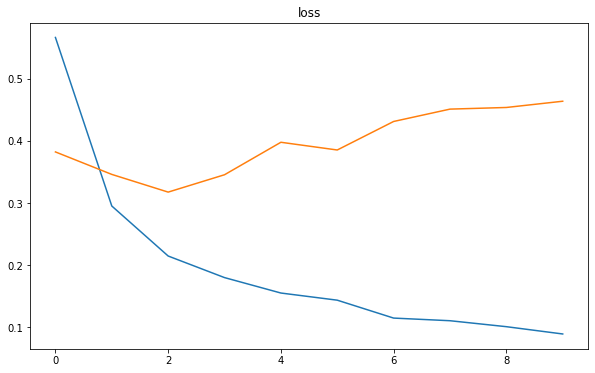

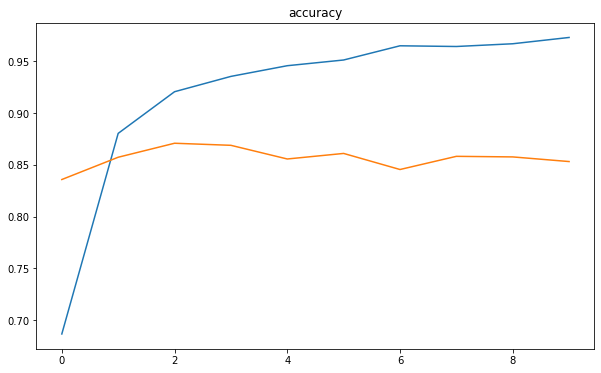

In [ ]:
#GRU
model = keras.models.Sequential()
model.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model.add(keras.layers.GRU(16))
model.add(keras.layers.Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(X_train_trim, y_train,epochs=10, batch_size=128, validation_data=(X_valid_trim, y_valid))

model.summary()

plot_loss(history)
plot_accuracy(history)

scores = model.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

##Bidirectional LSTM
Let's modify the previous code by using a bidirectional LSTM instead of a simple LSTM. In Keras, it is possible to define a bidirectional layer by using [tf.keras.layers.Bidirectional](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Bidirectional). Note that this wrapper requires as argument a layer, in our case we use [tf.keras.layers.LSTM](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM)


In [ ]:
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))

model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model_bidirectional.summary()

history = model_bidirectional.fit(X_train_trim, y_train,
                    epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 10)          100000    
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                11008     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 117s 578ms/step - loss: 0.6243 - accuracy: 0.6186 - val_loss: 0.3582 - val_accuracy: 0.8494
Epoch 2/5
196/196 [==============================] - 112s 570ms/step - loss: 0.2962 - accuracy: 0.8855 - val_loss: 0.2981 - val_accuracy: 0.8755
Epoch 3/5
196/196 [==============================] - 112s 573ms/step - loss: 0.2046 - ac

391/391 - 19s - loss: 0.3429 - accuracy: 0.8742
accuracy: 87.42%


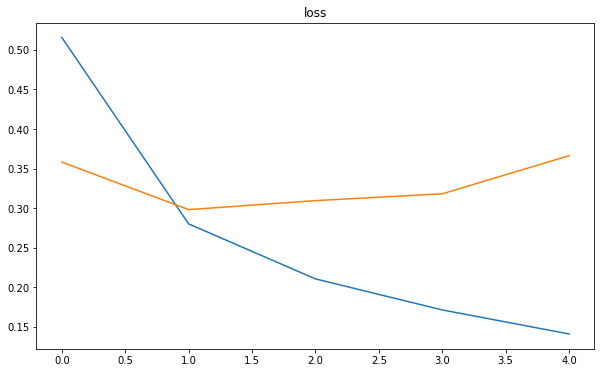

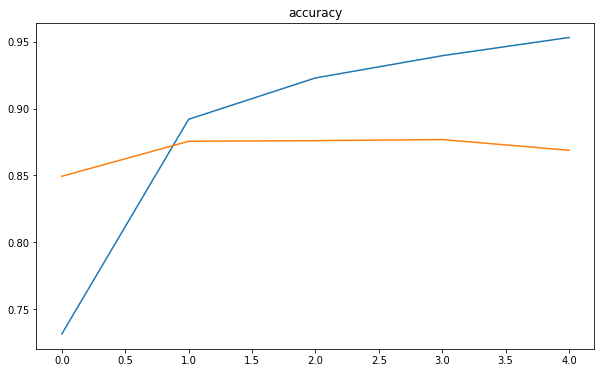

In [ ]:
plot_loss(history)

plot_accuracy(history)

scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

##[TO COMPLETE] Exercise 4.3: Dropout
In the bi-directional model is it possible to notice that the model overfits the training data.
A possible solution to this problem could be applying the dropout technique to input or output layers.

In Keras, to apply dropout you have to add a [keras.layers.Dropout](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout) layer.

**[TO COMPLETE]**: modify the code of the previous exercise adding the Dropout to the input and/or output layers. Find the Dropout probability that reduces the overfitting issue.

**[TO COMPLETE]** Is it possible to modify the values of some other hyper-parameters to mitigate overfitting? And if this is the case, explain why and perform an experimental study demonstrating your point.

*insert cells (code and text) with results and discussion immediately after this cell*

Discussion: 

The accuracy obtained is close to the bidirectional but the loss function decrease in both cases

- Dropout: I have tried different values (e.g. 0.3, 0.4, 0.1) and the best I have found is 0.25, in this case there is no situation of overfitting.

- Other hyperparameters: I tried to modify "output_dim" and "LSTM" (keras.layers.LSTM(12)) then the total parameters from 110000 (more or less) to 62000 (more or less) and  with the aim to reduce complexity of the model and the outcome achieved is very closed to "dropout" implementation.

The code is reported below

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 10)          100000    
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 10)          0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                11008     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 65        
Total params: 111,073
Trainable params: 111,073
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 121s 599ms/step - loss: 0.6328 - accuracy: 0.6308 - val_loss: 1.1884 - val_accuracy: 0.5223
Epoch 2/5
196/196 [==============================] - 116s 592ms/step - loss: 0.7084 - accuracy: 0.69

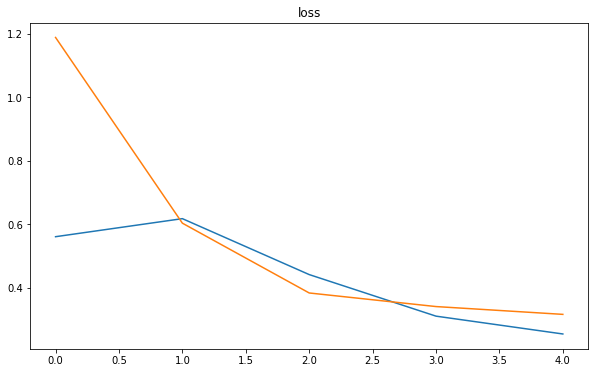

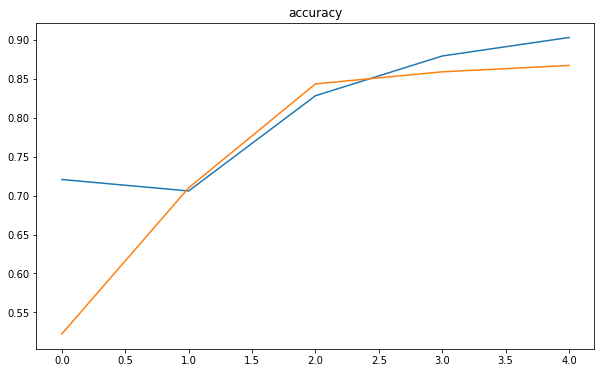

In [ ]:
#Dropout
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=10))
model_bidirectional.add(keras.layers.Dropout(0.25))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(32)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))
model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_bidirectional.summary()
history = model_bidirectional.fit(X_train_trim, y_train,epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))
plot_loss(history)
plot_accuracy(history)
scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, None, 6)           60000     
_________________________________________________________________
bidirectional_9 (Bidirection (None, 24)                1824      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 25        
Total params: 61,849
Trainable params: 61,849
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
196/196 [==============================] - 76s 368ms/step - loss: 0.6668 - accuracy: 0.5807 - val_loss: 0.5570 - val_accuracy: 0.7180
Epoch 2/5
196/196 [==============================] - 71s 364ms/step - loss: 0.4593 - accuracy: 0.8131 - val_loss: 0.3950 - val_accuracy: 0.8322
Epoch 3/5
196/196 [==============================] - 71s 363ms/step - loss: 0.3988 - accura

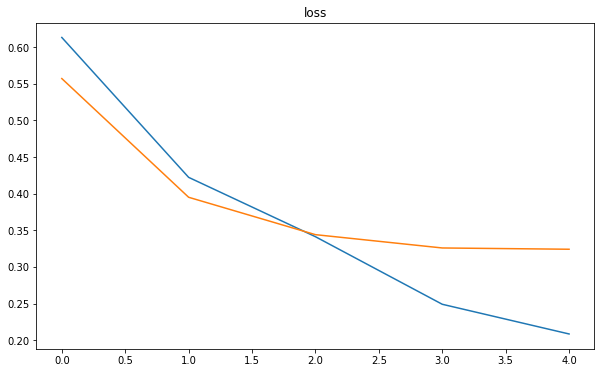

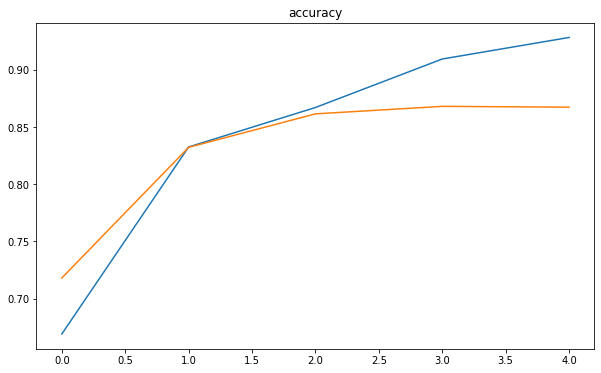

In [ ]:
#Avoid overfitting changing values
model_bidirectional = keras.models.Sequential()
model_bidirectional.add(keras.layers.Embedding(input_dim=num_words, output_dim=6))
model_bidirectional.add(keras.layers.Bidirectional(keras.layers.LSTM(12)))
model_bidirectional.add(keras.layers.Dense(1, activation="sigmoid"))
model_bidirectional.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model_bidirectional.summary()
history = model_bidirectional.fit(X_train_trim, y_train,epochs=5, batch_size=128, validation_data=(X_valid_trim, y_valid))
plot_loss(history)
plot_accuracy(history)
scores = model_bidirectional.evaluate(X_test_trim, y_test, verbose=2)
print("%s: %.2f%%" % (model_bidirectional.metrics_names[1], scores[1]*100))